In [1]:
%load_ext autoreload
%autoreload 2
from ins import comparison_tolerance

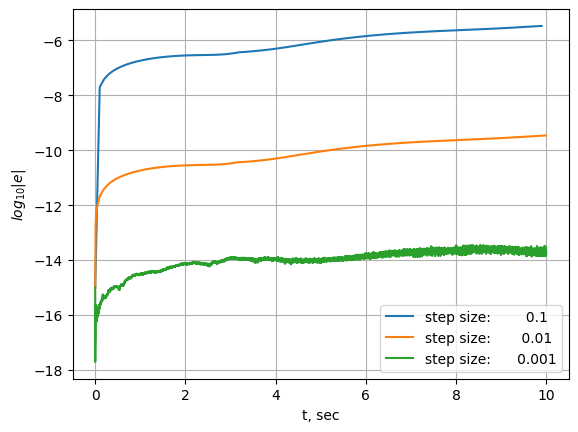

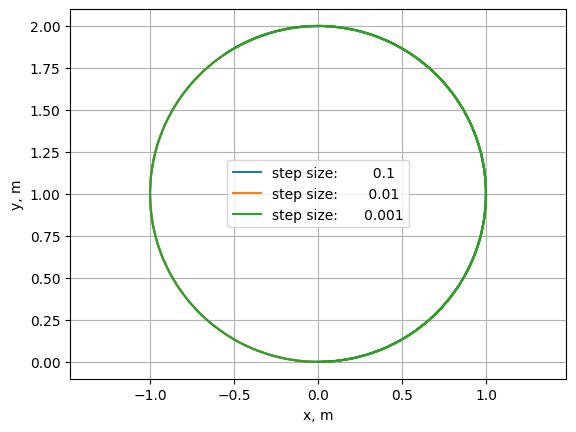

In [2]:
def circle_comparison():
    vx0 = 1
    r = 1
    ay = vx0**2 / r
    theta_dot = vx0 / r
    comparison_tolerance(
        "circle", [0, 0, 0, vx0, 0, 0, 0, 0, 0], [0, ay, -9.8], [0, 0, theta_dot]
    )


circle_comparison()

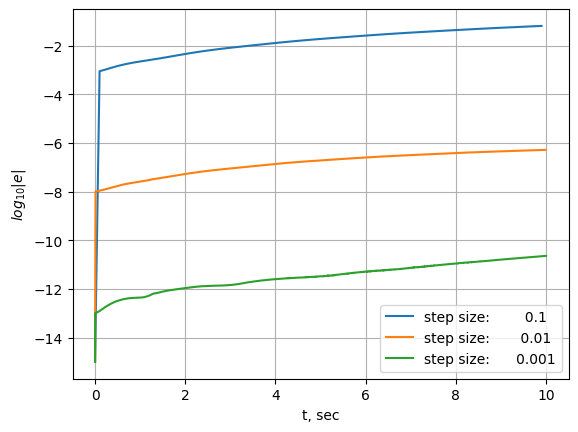

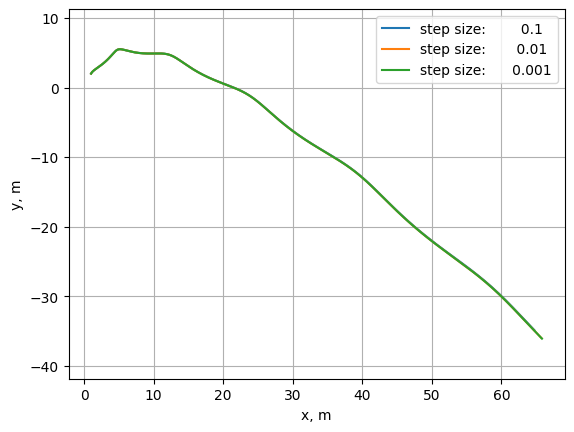

In [3]:
comparison_tolerance(
    "aggressive", [1, 2, 3, 1, 2, 3, 1, 2, 3], [1, 2, -9.8 + 3], [1, 0, 3]
)

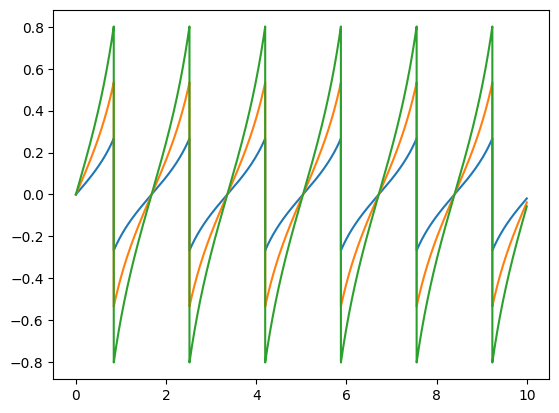

In [4]:
from ins import integrate_mixed_invariant, integrate_rk4

res = integrate_mixed_invariant(
    [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 9.8], [1, 2, 3], -9.8, 0.0001, 10
)
import matplotlib.pyplot as plt

plt.plot(res["t"], res["x"][:, 6:9])
plt.show()

In [5]:
from ins import find_flops

# find_flops()

In [6]:
from ins import draw_graphs

# draw_graphs()